# **IMPORT PACKAGE DAN MEMASUKAN DATA**

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# baca file excel yang sudah diupload
df = pd.read_excel("Data_Olah_Spasial.xlsx")

# ambil kolom yang dibutuhkan
df = df[["Tahun", "Kabupaten/Kota", "LAT", "LONG", "Y", "X1", "X2", "X3", "X4", "X5L"]]
df = df[df["Tahun"] == 2024]

# konversi ke GeoDataFrame
geometry = [Point(xy) for xy in zip(df["LONG"], df["LAT"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

gdf.info()

##Boxplot Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pilih kolom numerik & buang yang tidak relevan
num_cols = gdf.select_dtypes(include='number').columns.tolist()
# drop Tahun (konstan di 2024) and geographic coordinates (LAT, LONG)
num_cols = [c for c in num_cols if c.lower() not in ["tahun", "lat", "long"]]

# siapkan data per kolom (drop NaN/Inf)
data = [gdf[c].replace([np.inf, -np.inf], np.nan).dropna().values for c in num_cols]

plt.figure(figsize=(max(8, 1.4*len(num_cols)), 5.5))
bp = plt.boxplot(
    data,
    showmeans=True,
    meanline=False,
    patch_artist=True,   # agar box bisa diwarnai
    widths=0.6
)

# styling: warna lembut, median tegas, mean bulat
colors = plt.cm.Set2(np.linspace(0, 1, len(num_cols)))
for box, col in zip(bp['boxes'], colors):
    box.set(facecolor=col, edgecolor='#444', linewidth=1)
for med in bp['medians']:
    med.set(color='#222', linewidth=2)
for whisk in bp['whiskers']:
    whisk.set(color='#444', linewidth=1)
for cap in bp['caps']:
    cap.set(color='#444', linewidth=1)
for mean in bp['means']:
    mean.set(marker='o', markerfacecolor='white', markeredgecolor='#444', markersize=5)

plt.xticks(range(1, len(num_cols)+1), num_cols, rotation=35, ha='right')
plt.ylabel("Nilai")
plt.title("Boxplot Semua Variabel", pad=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

##Boxplot dari data yang distandarisasi

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
# Use the same numerical columns as the previous boxplot
data_std = scaler.fit_transform(gdf[num_cols].replace([np.inf,-np.inf], np.nan).dropna())

plt.figure(figsize=(max(8, 1.4*len(num_cols)), 5.5))
bp_std = plt.boxplot(
    [data_std[:, i] for i in range(data_std.shape[1])],
    showmeans=True,
    meanline=False,
    patch_artist=True,
    widths=0.6
)

# styling: warna ungu, median tegas, mean bulat
purple_color = '#800080' # Hex code for purple
for box in bp_std['boxes']:
    box.set(facecolor=purple_color, edgecolor='#444', linewidth=1)
for med in bp_std['medians']:
    med.set(color='#222', linewidth=2)
for whisk in bp_std['whiskers']:
    whisk.set(color='#444', linewidth=1)
for cap in bp_std['caps']:
    cap.set(color='#444', linewidth=1)
for mean in bp_std['means']:
    mean.set(marker='o', markerfacecolor='white', markeredgecolor='#444', markersize=5)


plt.xticks(range(1, data_std.shape[1]+1), num_cols, rotation=35, ha='right')
plt.ylabel("Z-score")
plt.title("Boxplot Semua Variabel (Distandarkan)", pad=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**MEMASUKAN DATA FILE SHP DARI GADM INDONESIA SERTA FILTER PULAU JAWA**

In [ ]:
import geopandas as gpd
import requests, zipfile, io

# 1. Download file ZIP shapefile GADM Indonesia
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IDN_shp.zip"
r = requests.get(url)

# 2. Ekstrak ke memori
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("gadm_idn")   # folder lokal "gadm_idn"

# 3. Baca shapefile level 2 (kabupaten/kota)
indo = gpd.read_file("gadm_idn/gadm41_IDN_2.shp")

print(indo.head())

# Filter hanya provinsi di Pulau Jawa
jawa_prov = ["Jakarta Raya", "Banten", "Jawa Barat", "Jawa Tengah", "Yogyakarta", "Jawa Timur"]
jawa = indo[indo["NAME_1"].isin(jawa_prov)]

# Cek kolom nama kabupaten/kota
print(jawa[["NAME_1","NAME_2"]].head())

# samakan key join: shapefile pakai NAME_2, data excel pakai "Kabupaten/Kota"
# bikin kolom baru dengan huruf besar kecil konsisten
gdf["Kabupaten_Kota"] = gdf["Kabupaten/Kota"].str.title()
jawa["Kabupaten_Kota"] = jawa["NAME_2"].str.title()


**MEMBUAT PETA INTERAKTIF**

In [ ]:
import folium

#membuat geometri pulau jawa
gdf = gdf.set_geometry(gdf.geometry.buffer(0))
jawa = jawa.set_geometry(jawa.geometry.buffer(0))

# Gabungkan shapefile Jawa dengan data Y
jawa_plot = jawa.merge(
    gdf[["Kabupaten/Kota", "Y"]],
    left_on="NAME_2", right_on="Kabupaten/Kota",
    how="left"
)

# Buat peta dasar
m = folium.Map(location=[-7.0, 110.0], zoom_start=7)

# Tambahkan data kabupaten/kota dengan warna berdasarkan nilai Y
choropleth = folium.Choropleth(
    geo_data=jawa_plot,
    data=jawa_plot,
    columns=["Kabupaten/Kota", "Y"],
    key_on="feature.properties.Kabupaten_Kota",
    fill_color="viridis",
    legend_name="Pengeluaran Rokok/Tembakau (Ribu Rp/kapita/minggu)",
).add_to(m)

# Tambahkan tooltip ke lapisan choropleth
folium.features.GeoJsonTooltip(
    fields=["Kabupaten/Kota", "Y"],
    aliases=["Kabupaten/Kota:", "Pengeluaran:"],
    localize=True,
).add_to(choropleth.geojson)

m

# **MEMBUAT KONTUR**


## Persiapan Data spasial pulau Jawa

In [ ]:

for province_name in jawa_prov:
    print(f"Processing data for province: {province_name}")

    # Filter data for the current province
    province_data = jawa_plot[jawa_plot["NAME_1"] == province_name].copy()

    # Extract geometry and 'Y'
    province_geometry_y = province_data[["geometry", "Y"]]

    # Display the first few rows of the extracted data for verification
    display(province_geometry_y.head())


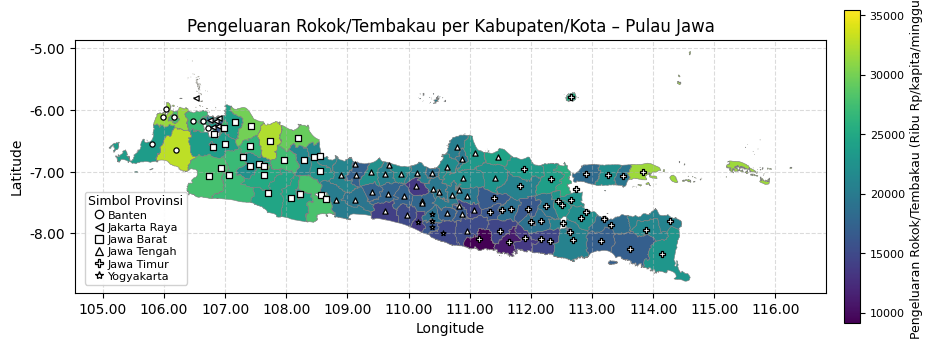

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib as mpl
import geopandas as gpd # Ensure geopandas is imported

# --- data siap pakai ---
# Reproject to WGS84 just in case for consistent lat/lon
jawa_plot_ll = jawa_plot.to_crs(epsg=4326).copy()
jawa_plot_ll["rep_pt"] = jawa_plot_ll.geometry.representative_point()
jawa_plot_ll["lon"] = jawa_plot_ll["rep_pt"].x
jawa_plot_ll["lat"] = jawa_plot_ll["rep_pt"].y

# ====== PARAM YANG DIPERKECIL ======
MARKER_SIZE = 14          # simbol di peta (lebih kecil)
LEG_MS      = 6           # simbol di legend (lebih kecil)
LEG_TEXT    = 8           # ukuran teks legend simbol
LEG_TITLE   = 9           # ukuran judul legend simbol
CBAR_SHRINK = 0.55        # mengecilkan tinggi colorbar
CBAR_LABEL  = 9           # ukuran label colorbar
CBAR_TICKS  = 8           # ukuran angka tick colorbar

PROV_MARKER = {
    "Banten":"o","DKI Jakarta":"X","Jawa Barat":"s",
    "Jawa Tengah":"^","DI Yogyakarta":"D","Jawa Timur":"P"
}
FALLBACK = ["v","<",">","d","p","*"]

vmin = np.nanmin(jawa_plot_ll["Y"]); vmax = np.nanmax(jawa_plot_ll["Y"])
# Using matplotlib.colormaps instead of deprecated get_cmap
cmap = mpl.colormaps.get_cmap("viridis")
norm = Normalize(vmin=vmin, vmax=vmax)


fig, ax = plt.subplots(figsize=(10, 6))

# 1) choropleth TANPA legend bawaan
jawa_plot_ll.plot(column="Y", ax=ax, cmap=cmap, norm=norm,
                  edgecolor="grey", linewidth=0.4, legend=False)

# 2) titik simbol per provinsi (kecil)
handles, seen = [], set()
# Use the correct column name for grouping if needed, assuming 'NAME_1' is the province name
for prov, sub in jawa_plot_ll.groupby("NAME_1"):
    mk = PROV_MARKER.get(prov, FALLBACK[len(seen) % len(FALLBACK)])
    ax.scatter(sub["lon"], sub["lat"], marker=mk, s=MARKER_SIZE,
               facecolor="white", edgecolor="black", linewidth=0.9, zorder=4)
    if prov not in seen:
        handles.append(Line2D([0],[0], marker=mk, linestyle="",
                              markerfacecolor="white", markeredgecolor="black",
                              markeredgewidth=0.9, markersize=LEG_MS, label=prov))
        seen.add(prov)

# 3) colorbar KECIL (manual)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, shrink=CBAR_SHRINK, pad=0.02)
cbar.set_label("Pengeluaran Rokok/Tembakau (Ribu Rp/kapita/minggu)", fontsize=CBAR_LABEL)
cbar.ax.tick_params(labelsize=CBAR_TICKS)

# 4) legend simbol KECIL (lokasi di kiri bawah)
leg = ax.legend(
    handles=handles,
    title="Simbol Provinsi",
    loc="lower left",
    bbox_to_anchor=(0.006, 0.01),
    frameon=True, framealpha=0.9,
    prop={'size': LEG_TEXT},
    title_fontsize=LEG_TITLE,
    borderpad=0.3, labelspacing=0.2,
    handlelength=1.0, handletextpad=0.3
)
# Corrected attribute name: legendHandles -> legend_handles
for h in leg.legend_handles:
    h.set_markersize(LEG_MS)

# 5) sumbu & grid
ax.set_title("Pengeluaran Rokok/Tembakau per Kabupaten/Kota – Pulau Jawa")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.45)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))


plt.tight_layout()
plt.show()

**PETA UNTUK MASING-MASING PROVINSI**

In [ ]:

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, LogLocator, LogFormatter, MaxNLocator
from matplotlib.colors import Normalize, LogNorm
import matplotlib.colors as mcolors
import geopandas as gpd

# ---------- Siapkan jawa_plot dari jawa + gdf ----------
if 'jawa_plot' not in globals():
    if all(c in gdf.columns for c in ['Kabupaten/Kota', 'Y']):
        jawa_plot = jawa.merge(
            gdf[['Kabupaten/Kota','Y']],
            left_on='NAME_2', right_on='Kabupaten/Kota',
            how='left'
        )
    else:
        raise ValueError("Pastikan gdf memiliki kolom 'Kabupaten/Kota' dan 'Y'.")

# Tambahkan X3 bila belum ada di jawa_plot
if "X3" not in jawa_plot.columns:
    if all(c in gdf.columns for c in ['Kabupaten/Kota','X3']):
        jawa_plot = jawa_plot.merge(
            gdf[['Kabupaten/Kota','X3']],
            left_on='NAME_2', right_on='Kabupaten/Kota',
            how='left'
        )
    else:
        raise ValueError("Kolom X3 tidak ditemukan di gdf. Pastikan gdf punya 'Kabupaten/Kota' dan 'X3'.")

# ---------- Layer lat-lon & titik representatif ----------
jawa_plot_ll = jawa_plot.to_crs(epsg=4326).copy()
jawa_plot_ll["rep_pt"] = jawa_plot_ll.geometry.representative_point()
jawa_plot_ll["lon"] = jawa_plot_ll["rep_pt"].x
jawa_plot_ll["lat"] = jawa_plot_ll["rep_pt"].y

def slug(s): return re.sub(r"[^A-Za-z0-9]+", "_", str(s)).strip("_")

# ---------- PARAM UMUM ----------
FIGSIZE = (7.4, 5.2); DPI = 300
GRID_MAJOR_STEP = 0.5

LABEL_FONT = dict(fontsize=8, fontfamily="DejaVu Sans",
                  fontweight="normal", color="black")

MARKER_SIZE = 46
MARKER_EDGE = "black"
MARKER_LINEWIDTH = 1.2
MARKER_FACE = "white"

# Simbol per provinsi (bisa diubah)
PROV_MARKER = {
    "Banten": "o",
    "DKI Jakarta": "X",
    "Jawa Barat": "s",
    "Jawa Tengah": "^",
    "DI Yogyakarta": "D",
    "Jawa Timur": "P",
}
FALLBACK_MARKERS = ["v","<",">","d","p","*"]

prov_list = sorted(jawa_plot_ll["NAME_1"].dropna().unique().tolist())

def plot_per_province(column, cmap, legend_label, title_prefix, use_log=False,
                      cbar_decade_ticks=True, cbar_linear_nticks=5):

    # ===== ukuran kecil =====
    TICK_FONTSIZE = 7              # angka sumbu
    AXLABEL_FONTSIZE = 8           # label sumbu
    CBAR_TICK_FONTSIZE = 7         # angka di colorbar
    CBAR_LABEL_FONTSIZE = 8        # label colorbar
    POINT_LEGEND_FONTSIZE = 7      # teks legend titik
    POINT_LEGEND_MARKERSCALE = 0.6 # skala simbol di legend titik

    # skala warna global kolom tsb (konsisten antar provinsi)
    vals = jawa_plot_ll[column].to_numpy(dtype=float)
    if not np.isfinite(vals).any():
        raise ValueError(f"Tidak ada nilai valid untuk kolom '{column}'.")
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))

    if use_log:
        # pastikan vmin>0 untuk skala log
        if vmin <= 0:
            vmin = float(np.nanmin(vals[vals > 0])) if np.any(vals > 0) else 1e-6
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = Normalize(vmin=vmin, vmax=vmax)

    fb_i = 0
    for prov in prov_list:
        sub = jawa_plot_ll.loc[jawa_plot_ll["NAME_1"].eq(prov)].copy()
        if sub.empty:
            continue

        mk = PROV_MARKER.get(prov, FALLBACK_MARKERS[fb_i % len(FALLBACK_MARKERS)])
        if prov not in PROV_MARKER:
            fb_i += 1

        fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

        # boundary + choropleth (tanpa legend bawaan ↔ kita buat colorbar sendiri)
        sub.dissolve(by="NAME_1").boundary.plot(ax=ax, color="black", linewidth=0.9)
        sub.plot(
            column=column, ax=ax, cmap=cmap, norm=norm,
            edgecolor="grey", linewidth=0.5, legend=False
        )

        # titik koordinat – simbol sama untuk semua kab/kota di provinsi ini
        ax.scatter(
            sub["lon"], sub["lat"],
            marker=mk, s=MARKER_SIZE,
            facecolor=MARKER_FACE, edgecolor=MARKER_EDGE, linewidth=MARKER_LINEWIDTH,
            zorder=4, label="Titik koordinat"
        )

        # label nama kab/kota
        for _, r in sub.iterrows():
            ax.text(r["lon"], r["lat"], r["NAME_2"], ha="center", va="bottom", zorder=5, **LABEL_FONT)

        # sumbu lat–lon + grid
        ax.set_title(f"{prov} – {title_prefix}", fontsize=11)
        ax.set_xlabel("Longitude", fontsize=AXLABEL_FONTSIZE)
        ax.set_ylabel("Latitude",  fontsize=AXLABEL_FONTSIZE)
        ax.grid(True, linestyle="--", alpha=0.45)
        ax.xaxis.set_major_locator(MultipleLocator(GRID_MAJOR_STEP))
        ax.yaxis.set_major_locator(MultipleLocator(GRID_MAJOR_STEP))
        ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
        ax.tick_params(axis="both", labelsize=TICK_FONTSIZE)

        # === COLORBAR KUSTOM (lengkap) ===
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])  # placeholder untuk colorbar
        cbar = fig.colorbar(
            sm, ax=ax, fraction=0.06, pad=0.02, shrink=0.7, aspect=20  # kecil & ramping
        )
        cbar.set_label(legend_label, fontsize=CBAR_LABEL_FONTSIZE)
        cbar.ax.tick_params(labelsize=CBAR_TICK_FONTSIZE)

        if use_log:
            if cbar_decade_ticks:
                # Tick tiap dekade (10^k)
                dmin = int(np.floor(np.log10(vmin)))
                dmax = int(np.ceil (np.log10(vmax)))
                locator = LogLocator(base=10.0, subs=(1.0,), numticks=max(dmax - dmin + 1, 2))
                formatter = LogFormatter(base=10.0, labelOnlyBase=False)
                cbar.locator = locator
                cbar.formatter = formatter
                cbar.update_ticks()
            # — Alternatif: tick kustom —
            # ticks = [5e4, 2e5, 1e6, 5e6]
            # cbar.set_ticks(ticks)
            # cbar.set_ticklabels([f"{int(t):,}" for t in ticks])
        else:
            cbar.locator = MaxNLocator(nbins=cbar_linear_nticks)
            cbar.update_ticks()

        # LEGEND titik kecil
        ax.legend(
            loc="lower left", frameon=True, framealpha=0.85,
            prop={'size': POINT_LEGEND_FONTSIZE},
            markerscale=POINT_LEGEND_MARKERSCALE,
            handlelength=0.8, handletextpad=0.3, borderpad=0.3, labelspacing=0.2
        )

        out_path = f"peta_{slug(prov)}_{slug(column)}.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=DPI)
        plt.show()
        print(f"✔ Disimpan: {out_path}")

# =======================
# Peta Y (linear)
plot_per_province(
    column="Y",
    cmap="viridis",
    legend_label="Pengeluaran Rokok/Tembakau\n(Ribu Rp/kapita/minggu)",
    title_prefix="Pengeluaran Rokok/Tembakau per Kabupaten/Kota",
    use_log=False,
    cbar_linear_nticks=6
)

# Peta X3 (Jumlah Penduduk) – log dgn tick tiap dekade (lengkap)
plot_per_province(
    column="X3",
    cmap="plasma",
    legend_label="Jumlah Penduduk",
    title_prefix="Jumlah Penduduk per Kabupaten/Kota",
    use_log=True,             # log-scale cocok untuk populasi yang sangat bervariasi
    cbar_decade_ticks=True
)


**MEMBUAT PLOT 3D UNTUK PENGELUARAN KONSUMSI ROKOK DAN JUMLAH PENDUDUK BERDASARKAN JARAK**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

# ====== MARKER PROVINSI ======
PROV_MARKER = {
    "Banten": "o",
    "DKI Jakarta": "X",
    "Jawa Barat": "s",
    "Jawa Tengah": "^",
    "DI Yogyakarta": "D",
    "Jawa Timur": "P",
}
FALLBACK_MARKERS = ["v", "<", ">", "d", "p", "*"]

# ====== EKSTRAK DATA ======
x_coord = gdf["LONG"].to_numpy()
y_coord = gdf["LAT"].to_numpy()
Y = gdf["Y"].to_numpy()           # Pengeluaran rokok
X = gdf["X3"].to_numpy()          # Jumlah penduduk
lokasi = gdf["Kabupaten/Kota"].to_numpy()

# ====== PROVINSI ======
if "Provinsi" in gdf.columns:
    provinsi = gdf["Provinsi"].to_numpy()
else:
    kab_to_prov = dict(zip(jawa["NAME_2"], jawa["NAME_1"]))
    provinsi = np.array([kab_to_prov.get(k, "Lainnya") for k in lokasi], dtype=object)

# ====== HITUNG JARAK KE BANDUNG ======
bandung_data = gdf[gdf["Kabupaten/Kota"] == "Kota Bandung"]
if len(bandung_data) == 0:
    raise ValueError("Data Kota Bandung tidak ditemukan!")

x0, y0 = bandung_data[["LONG", "LAT"]].values[0]
jarak = np.array([geodesic((y0, x0), (lat, lon)).km for lat, lon in zip(y_coord, x_coord)])

# ====== KLASIFIKASI JARAK (STURGES FIXED) ======
n = len(jarak)
k = max(3, int(np.ceil(1 + 3.3 * np.log10(n))))  # Min 3 kelas

# FIX: Gunakan interval sama, bukan quantile
jarak_min, jarak_max = jarak.min(), jarak.max()
edges = np.linspace(jarak_min, jarak_max, k + 1)

# Handle edge case untuk nilai tepat di batas
eps = 1e-6 * (jarak_max - jarak_min)
edges[0] -= eps
edges[-1] += eps

kelas = np.digitize(jarak, edges[1:-1], right=True) + 1
kelas = np.clip(kelas, 1, k)

# ====== PALET WARNA SESUAI PERMINTAAN ======
kelas_unique = np.unique(kelas)

# ---------- PALET: buat warna kelas & colormap LISTED agar MATCH legend ----------
base = plt.get_cmap("turbo")
colors_k = [base((i - 0.5) / k) for i in range(1, k + 1)]   # 1..k -> titik tengah
cmap = ListedColormap(colors_k)                              # pakai warna yang sama persis
norm = BoundaryNorm(np.arange(0.5, k + 1.5, 1), ncolors=k)   # diskrit 1..k

color_lookup = {cls_num: colors_k[i] for i, cls_num in enumerate(sorted(kelas_unique))}

# ====== PLOT 3D ======
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")

# ====== PLOT PER PROVINSI ======
prov_unique = np.unique(provinsi)
fallback_idx = 0

for prov in prov_unique:
    mask = (provinsi == prov)
    marker = PROV_MARKER.get(prov, FALLBACK_MARKERS[fallback_idx % len(FALLBACK_MARKERS)])
    if prov not in PROV_MARKER:
        fallback_idx += 1

    # Gunakan color_lookup untuk warna yang konsisten
    scatter_colors = [color_lookup[cls] for cls in kelas[mask]]

    ax.scatter(
        X[mask], Y[mask], jarak[mask],
        c=scatter_colors,  # Langsung gunakan warna dari lookup
        marker=marker, s=70, edgecolor="white", linewidth=0.8,
        alpha=0.9, label=prov
    )

# ====== HIGHLIGHT KOTA BANDUNG ======
bandung_mask = (lokasi == "Kota Bandung")
if np.any(bandung_mask):
    ax.scatter(
        X[bandung_mask], Y[bandung_mask], jarak[bandung_mask],
        color="red", marker="*", s=300, edgecolor="gold",
        linewidth=2, zorder=10, label="Kota Bandung"
    )

# ====== AXIS LABELS & TITLE ======
ax.set_xlabel("Jumlah Penduduk (ribu)", fontsize=11, labelpad=10)
ax.set_ylabel("Pengeluaran Rokok (rupiah)", fontsize=11, labelpad=10)
ax.set_zlabel("Jarak dari Bandung (km)", fontsize=11, labelpad=10)

ax.set_title(
    "3D Scatter: Pengeluaran Rokok vs Jumlah Penduduk\n"
    "dengan Jarak Geografis dari Kota Bandung",
    fontsize=13, pad=20, weight='bold'
)

# ====== GRID & APPEARANCE ======
ax.grid(True, alpha=0.3)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')

# ====== LEGEND KELAS JARAK (TOP) ======
class_handles = [
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor=colors_k[i], markeredgecolor='black',
           markersize=8, label=f'K{i+1}')
    for i in range(k)
]

class_legend = ax.legend(
    handles=class_handles,
    title="Kelas Jarak (Sturges)", title_fontsize=10,
    loc='upper center', bbox_to_anchor=(0.5, 1.15),
    ncol=min(k, 6), fontsize=9, framealpha=0.95,
    handletextpad=0.5, columnspacing=1
)

# ====== LEGEND PROVINSI (BOTTOM) ======
prov_handles = []
for prov in prov_unique:
    marker = PROV_MARKER.get(prov, FALLBACK_MARKERS[0])
    prov_handles.append(
        Line2D([0], [0], marker=marker, linestyle='None',
               markerfacecolor='lightgray', markeredgecolor='black',
               markersize=8, label=prov)
    )

# Tambahkan Kota Bandung ke legend
prov_handles.append(
    Line2D([0], [0], marker='*', linestyle='None',
           markerfacecolor='red', markeredgecolor='gold',
           markersize=10, label='Kota Bandung')
)

prov_legend = ax.legend(
    handles=prov_handles,
    title="Provinsi", title_fontsize=10,
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    ncol=4, fontsize=9, framealpha=0.95
)

# Tambahkan kedua legend
ax.add_artist(class_legend)

# ====== LAYOUT OPTIMIZATION ======
plt.tight_layout()
fig.subplots_adjust(top=0.88, bottom=0.18)

# ====== INFO BOX ======
info_text = f"Total: {n} kabupaten/kota | {k} kelas jarak | Sumber: Data Jawa"
fig.text(0.02, 0.02, info_text, fontsize=8, alpha=0.7)

# ====== SAVE & SHOW ======
plt.savefig('visualisasi_3d_bandung.png', dpi=300, bbox_inches='tight')
plt.show()

# ====== PRINT SUMMARY ======
print("=" * 50)
print("SUMMARY KLASIFIKASI JARAK")
print("=" * 50)
for i in range(k):
    count = np.sum(kelas == i+1)
    print(f"Kelas {i+1}: {edges[i]:7.1f} - {edges[i+1]:7.1f} km → {count:2d} wilayah")

print(f"\nJarak minimum: {jarak_min:.1f} km")
print(f"Jarak maksimum: {jarak_max:.1f} km")
print(f"Interval per kelas: {(jarak_max - jarak_min)/k:.1f} km")









## PETA SEBARAN PENGELUARAN VS JUMLAH PENDUDUK PER KELAS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from geopy.distance import geodesic # Import geodesic for distance calculation
from matplotlib.colors import BoundaryNorm, ListedColormap # Import for colormap and norm

# ====== Ambil provinsi & nama kab/kota (robust) ======
try:
    provinsi  # kalau sudah ada variabel ini, pakai saja
except NameError:
    provinsi = gdf["Provinsi"].to_numpy() if "Provinsi" in gdf.columns else gdf["Kabupaten/Kota"].map(dict(zip(jawa["NAME_2"], jawa["NAME_1"]))).fillna("Lainnya").to_numpy()

try:
    lokasi  # nama kab/kota
except NameError:
    lokasi = gdf["Kabupaten/Kota"].to_numpy()

# ====== Calculate distance from Kota Bandung and determine distance classes ======
x_coord = gdf["LONG"].to_numpy()
y_coord = gdf["LAT"].to_numpy()

# Find coordinates for Kota Bandung
try:
    x0, y0 = gdf.loc[gdf["Kabupaten/Kota"] == "Kota Bandung", ["LONG","LAT"]].values[0]
except IndexError:
    print("Kota Bandung not found in data. Cannot calculate distance classes.")
    jarak_kelas = np.full(len(gdf), np.nan) # Assign NaN to all to skip plotting by class
else:
    # Calculate distance
    jarak = np.array([geodesic((y0, x0), (lat, lon)).km for lat, lon in zip(y_coord, x_coord)])

    # Determine distance classes using Sturges' rule and quantiles
    n = len(jarak)
    k = int(np.ceil(1 + 3.3 * np.log10(n)))
    edges = np.quantile(jarak, np.linspace(0, 1, k + 1))
    edges = np.unique(edges)
    if edges.size < k + 1:
        eps = 1e-6 * (np.max(jarak) - np.min(jarak) + 1.0)
        edges = np.linspace(np.min(jarak) - eps, np.max(jarak) + eps, k + 1)

    jarak_kelas = np.digitize(jarak, edges[1:-1], right=False) + 1  # 1..k
    jarak_kelas = np.clip(jarak_kelas, 1, k)

# ====== Mapping simbol per provinsi ======
PROV_MARKER = {
    "Banten": "o",
    "DKI Jakarta": "X",
    "Jawa Barat": "s",
    "Jawa Tengah": "^",
    "DI Yogyakarta": "D",
    "Jawa Timur": "P",
}
FALLBACK = ["v","<",">","d","p","*"]  # untuk provinsi di luar 6 ini

prov_unique = list(dict.fromkeys(provinsi))  # urut berdasar kemunculan
fallback_i = 0
prov_marker_map = {}
for p in prov_unique:
    prov_marker_map[p] = PROV_MARKER.get(p, FALLBACK[fallback_i % len(FALLBACK)])
    if p not in PROV_MARKER:
        fallback_i += 1

# ====== Warna per kelas (satu warna per gambar) ======
kelas_unique = np.unique(jarak_kelas)

# ---------- PALET: buat warna kelas & colormap LISTED agar MATCH legend ----------
n = len(jarak)
k = int(np.ceil(1 + 3.3 * np.log10(n)))
base = plt.get_cmap("turbo")
colors_k = [base((i - 0.5) / k) for i in range(1, k + 1)]
cmap = ListedColormap(colors_k)
norm = BoundaryNorm(np.arange(0.5, k + 1.5, 1), ncolors=k)

color_lookup = {cls_num: colors_k[i] for i, cls_num in enumerate(sorted(kelas_unique))}

# ====== Data X & Y ======
penduduk_miskin = gdf["X3"].to_numpy()
pengeluaran_rokok = gdf["Y"].to_numpy()

X = penduduk_miskin
Y = pengeluaran_rokok

# ====== Determine global axis limits ======
x_min_global, x_max_global = np.nanmin(X), np.nanmax(X)
y_min_global, y_max_global = np.nanmin(Y), np.nanmax(Y)

# Add a small buffer to the limits
x_buffer = (x_max_global - x_min_global) * 0.05
y_buffer = (y_max_global - y_min_global) * 0.05

x_lim = (x_min_global - x_buffer, x_max_global + x_buffer)
y_lim = (y_min_global - y_buffer, y_max_global + y_buffer)


# ====== Loop: satu gambar per kelas ======
for k in sorted(kelas_unique): # Iterate through sorted unique classes
    m_k = (jarak_kelas == k)
    if not np.any(m_k):
        continue

    fig, ax = plt.subplots(figsize=(6.2, 5.2))
    col = color_lookup[k]

    # plot per provinsi agar marker beda
    for p in prov_unique:
        m = m_k & (provinsi == p)
        if not np.any(m):
            continue
        ax.scatter(
            X[m], Y[m],
            s=120,
            color=col, marker=prov_marker_map[p],
            edgecolor="k", linewidth=0.8, alpha=0.95
        )

    # sumbu & judul
    ax.set_title(f"Pengeluaran Rokok Tembakau vs Jumlah Penduduk — Kelas Jarak K{k}", fontsize=10)
    ax.set_xlabel("Jumlah Penduduk", fontsize=10)
    ax.set_ylabel("Pengeluaran Rokok", fontsize=10)
    ax.grid(True, ls="--", alpha=0.4)

    # Set axis limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # Perbesar ukuran font ticks
    ax.tick_params(axis='both', which='major', labelsize=10)

    # legend simbol (provinsi) saja - juga diperbesar
    handles_symbols = [
        Line2D([0],[0], marker=prov_marker_map[p], linestyle='None',
               markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.9,
               markersize=10, label=p)
        for p in prov_unique if np.any(m_k & (provinsi == p))
    ]
    leg = ax.legend(handles=handles_symbols, title="Simbol: Provinsi",
                    loc="lower right", frameon=True, framealpha=0.9,
                    fontsize=10, title_fontsize=11,
                    labelspacing=0.3, handlelength=1.0, handletextpad=0.5, borderpad=0.4)

    plt.tight_layout()
    # simpan (opsional)
    # plt.savefig(f"scatter_kelas_K{k}.png", dpi=300, bbox_inches='tight')
    plt.show()

# **PEMODELAN SEMIVARIOGRAM**

#Semivariogram untuk tiap provinsi

In [ ]:
# ==================== VARIOGRAM 4 PROVINSI (tanpa DKI & DIY) ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from itertools import combinations
import re

# ---------- 0) Siapkan data: representative point & WGS84 ----------
# Asumsi: GeoDataFrame `jawa_plot` sudah ada (polygon kab/kota + kolom "Y", "NAME_1", "NAME_2")
jawa_ll = jawa_plot.to_crs(epsg=4326).copy()
jawa_ll["pt"]  = jawa_ll.geometry.representative_point()
jawa_ll["lon"] = jawa_ll["pt"].x
jawa_ll["lat"] = jawa_ll["pt"].y

# ---------- 1) Utilitas ----------
def utm_epsg_south(lon):
    """Pilih EPSG UTM (hemisfer selatan) berdasar longitude rata-rata (derajat)."""
    zone = int(np.floor((lon + 180) / 6) + 1)  # 1..60
    return 32700 + zone  # 327xx = WGS84 / UTM south

def slug(s):  # untuk nama file
    return re.sub(r"[^A-Za-z0-9]+", "_", str(s)).strip("_")

def pairwise_semivariance(dist, z, bins, min_pairs=3):
    """
    Semivariogram empiris: untuk tiap bin jarak h,
    gamma(h) = 0.5 * mean( (z_i - z_j)^2 ) pada pasangan i<j dengan jarak dalam bin tsb.
    """
    n = len(z)
    idxs = np.triu_indices(n, k=1)            # pasangan i<j
    dij  = dist[idxs]                          # jarak
    dz2  = 0.5 * (z.reshape(-1,1) - z.reshape(1,-1))**2
    gam  = dz2[idxs]                           # semivariance per pasangan

    hc, gamma_emp, counts = [], [], []
    for b0, b1 in zip(bins[:-1], bins[1:]):
        m = (dij >= b0) & (dij < b1)
        cnt = int(np.count_nonzero(m))
        if cnt >= min_pairs:
            hc.append(0.5*(b0+b1))
            gamma_emp.append(float(np.mean(gam[m])))
            counts.append(cnt)
    return np.array(hc), np.array(gamma_emp), np.array(counts)

# ---------- 2) Model variogram ----------
def vg_spherical(h, nugget, sill, rng):
    h = np.asarray(h)
    y = np.where(
        h <= rng,
        nugget + (sill - nugget)*(1.5*(h/rng) - 0.5*(h/rng)**3),
        nugget + (sill - nugget)
    )
    return y

def vg_exponential(h, nugget, sill, rng):
    h = np.asarray(h)
    return nugget + (sill - nugget)*(1.0 - np.exp(-h / rng))

def vg_gaussian(h, nugget, sill, rng):
    h = np.asarray(h)
    return nugget + (sill - nugget)*(1.0 - np.exp(-(h**2) / (rng**2)))

def rmse(y, yhat):
    return float(np.sqrt(np.mean((y - yhat)**2)))

def fit_one_model(hc, gamma_emp, model_fn):
    """
    Fit SATU model variogram (model_fn) via grid-search ringan.
    Return dict params: {"nugget","sill","rng","rmse"}.
    """
    if len(hc) < 3:
        return None
    sill0 = float(np.max(gamma_emp)) if len(gamma_emp) else 1.0
    a0    = float(np.percentile(hc, 75)) if len(hc) else 1.0

    # grid parameter sederhana (bisa diperlebar bila perlu)
    nug_candidates  = np.linspace(0.0, max(1e-6, 0.5*sill0), 4)
    sill_candidates = np.linspace(max(1e-6, 0.8*sill0), max(1e-6, 1.2*sill0), 5)
    a_candidates    = np.linspace(max(1e-6, 0.3*a0), max(1e-6, 1.5*a0), 8)

    best = None
    for nug in nug_candidates:
        for sil in sill_candidates:
            for rng in a_candidates:
                yhat = model_fn(hc, nug, sil, rng)
                e = rmse(gamma_emp, yhat)
                if (best is None) or (e < best["rmse"]):
                    best = {"nugget": float(nug), "sill": float(sil), "rng": float(rng), "rmse": float(e)}
    return best

# ---------- 3) Daftar provinsi (kecualikan DKI & DIY) ----------
# prov_exclude = {"DKI Jakarta", "DI Yogyakarta"} # Remove exclusion
prov_list_all = sorted(jawa_ll["NAME_1"].dropna().unique().tolist())
prov_list = [p for p in prov_list_all if p in ["Banten", "DKI Jakarta", "Jawa Barat", "Jawa Tengah", "DI Yogyakarta", "Jawa Timur"]] # Include all 6 provinces

# ---------- 4) Jalankan: variogram + plot 3 model overlay ----------
results = []

for prov in prov_list:
    sub = jawa_ll.loc[jawa_ll["NAME_1"].eq(prov)].copy()
    sub = sub.dropna(subset=["Y"])
    npts = len(sub)
    if npts < 5:
        # butuh cukup banyak titik untuk variogram yang stabil
        print(f"[skip] {prov}: titik kab/kota terlalu sedikit (n={npts})")
        continue

    # CRS metrik (UTM) per provinsi
    epsg = utm_epsg_south(sub["lon"].mean())
    subm = sub.to_crs(epsg=epsg).copy()
    subm["cx"] = subm.geometry.representative_point().x
    subm["cy"] = subm.geometry.representative_point().y

    # jarak euclidean (meter)
    coords = subm[["cx","cy"]].to_numpy()
    z = subm["Y"].to_numpy()
    dx = coords[:,0][:,None] - coords[:,0][None,:]
    dy = coords[:,1][:,None] - coords[:,1][None,:]
    dist = np.sqrt(dx*dx + dy*dy)

    # bin jarak adaptif (supaya prov kecil tetap dapat ≥3 bin)
    dmax = float(np.nanmax(dist))
    if npts <= 5:
        nbin, max_frac = 5, 1.0
    elif npts <= 8:
        nbin, max_frac = 7, 0.9
    else:
        nbin, max_frac = 10, 0.8
    bins = np.linspace(0.0, max_frac*dmax, nbin+1)

    hc, gamma_emp, counts = pairwise_semivariance(dist, z, bins, min_pairs=3)
    if len(hc) < 3:
        # fallback: pakai bin kuantil supaya lebih terisi
        idxs = np.triu_indices(npts, k=1)
        dij = dist[idxs]
        qbins = np.quantile(dij, np.linspace(0, 1, 6 if npts>=5 else 5))
        qbins = np.unique(qbins)
        hc, gamma_emp, counts = pairwise_semivariance(dist, z, qbins, min_pairs=3)
    if len(hc) < 3:
        print(f"[skip] {prov}: bin variogram tetap kurang (n={npts})")
        continue

    # --- Fit 3 model teoretis (masing-masing) ---
    fit_sph = fit_one_model(hc, gamma_emp, vg_spherical)
    fit_exp = fit_one_model(hc, gamma_emp, vg_exponential)
    fit_gau = fit_one_model(hc, gamma_emp, vg_gaussian)

    # --- Plot: empirical + ketiga kurva sekaligus ---
    hs = np.linspace(0, hc.max()*1.1, 250)
    y_sph = vg_spherical(hs, fit_sph["nugget"], fit_sph["sill"], fit_sph["rng"])
    y_exp = vg_exponential(hs, fit_exp["nugget"], fit_exp["sill"], fit_exp["rng"])
    y_gau = vg_gaussian(hs, fit_gau["nugget"], fit_gau["sill"], fit_gau["rng"])

    fig, ax = plt.subplots(figsize=(6.8, 4.4))
    ax.scatter(hc, gamma_emp, s=26, color="black", label="Empirical γ(h)")
    ax.plot(hs, y_sph, lw=2.0, label=f"Spherical (RMSE={fit_sph['rmse']:.3g})")
    ax.plot(hs, y_exp, lw=2.0, label=f"Exponential (RMSE={fit_exp['rmse']:.3g})")
    ax.plot(hs, y_gau, lw=2.0, label=f"Gaussian (RMSE={fit_gau['rmse']:.3g})")
    ax.set_xlabel("Lag distance (meter)")
    ax.set_ylabel("Semivariance γ(h)")
    ax.set_title(f"Semivariogram – {prov}")
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    ax.grid(True, ls="--", alpha=0.4)
    ax.legend()
    plt.tight_layout()
    # plt.savefig(f"variogram_{slug(prov)}_3model.png", dpi=300)
    plt.show()

    # simpan ringkasan parameter
    results += [
        {"Provinsi": prov, "Model": "spherical",  **fit_sph, "EPSG_UTM": epsg, "n_points": npts},
        {"Provinsi": prov, "Model": "exponential", **fit_exp, "EPSG_UTM": epsg, "n_points": npts},
        {"Provinsi": prov, "Model": "gaussian",    **fit_gau, "EPSG_UTM": epsg, "n_points": npts},
    ]

# ---------- 5) Tabel parameter ketiga model (per provinsi) ----------
tabel_variogram_3model = (
    pd.DataFrame(results)
    .rename(columns={"rng":"Range_meter", "nugget":"Nugget", "sill":"Sill", "rmse":"RMSE"})
    .sort_values(["Provinsi","Model"])
)
print(tabel_variogram_3model)
# contoh simpan:
# tabel_variogram_3model.to_csv("variogram_params_3model_4prov.csv", index=False)

**SEMIVARIOGRAM UNTUK PULAU JAWA DAN ORDINARY KRIGING**

In [ ]:
# ====================== VARIOGRAM & KRIGING – AGREGAT 6 PROVINSI ======================
!pip install pykrige

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
from shapely.prepared import prep
import shapely  # <--- penting, dipakai untuk contains_xy
from pyproj import Transformer

# --- shapely.vectorized (jika ada) untuk masking cepat ---
try:
    from shapely import vectorized as shpvec
    HAS_VEC = True
except Exception:
    HAS_VEC = False

gdf_2023 = gdf.loc[gdf["Tahun"] == 2024, ["Kabupaten/Kota", "Y"]].copy()

# Gabungkan ke shapefile Jawa supaya kolom Y adalah Y(2023)
jawa_plot = jawa.merge(
    gdf_2023, left_on="NAME_2", right_on="Kabupaten/Kota", how="left"
)

# ---------- PARAMETER ----------
PROV_6      = ["Banten","DKI Jakarta","Jawa Barat","Jawa Tengah","DI Yogyakarta","Jawa Timur"]
GRID_RES_M  = 1000     # resolusi grid kriging (meter). Naikkan untuk lebih cepat, turunkan untuk lebih halus.
BORDER_PAD  = 0.05
CMAP        = "viridis"
POINT_SIZE  = 22        # ukuran titik sampel di peta

# Simbol per provinsi
PROV_MARKER = {
    "Banten":"o","DKI Jakarta":"X","Jawa Barat":"s",
    "Jawa Tengah":"^","DI Yogyakarta":"D","Jawa Timur":"P"
}

# Legend kecil (simbol provinsi)
LEGEND_CFG = {
    "title": "Simbol Provinsi",
    "fontsize": 7, "title_fontsize": 8,
    "markersize": 6, "frame": True, "framealpha": 0.8,
    "loc": "lower left", "bbox_to_anchor": (0.015, 0.015),
    "ncol": 1, "labelspacing": 0.12, "handlelength": 0.5,
    "handletextpad": 0.25, "borderpad": 0.25
}

# ---------- UTIL ----------
def utm_epsg_south(lon):
    zone = int(np.floor((lon + 180) / 6) + 1)
    return 32700 + zone  # WGS84/UTM (Southern Hemisphere)

def pairwise_semivariance(dist, z, bins, min_pairs=4):
    n = len(z)
    i,j = np.triu_indices(n,1)
    dij = dist[i,j]
    gam = 0.5*(z[:,None]-z[None,:])**2
    gam = gam[i,j]
    hc, ge, ct = [], [], []
    for b0,b1 in zip(bins[:-1], bins[1:]):
        m = (dij >= b0) & (dij < b1)
        c = int(np.count_nonzero(m))
        if c >= min_pairs:
            hc.append(0.5*(b0+b1)); ge.append(float(np.mean(gam[m]))); ct.append(c)
    return np.array(hc), np.array(ge), np.array(ct)

# model variogram
def vg_spherical(h, nugget, sill, rng):
    h = np.asarray(h)
    return np.where(h<=rng, nugget+(sill-nugget)*(1.5*(h/rng)-0.5*(h/rng)**3), nugget+(sill-nugget))
def vg_exponential(h, nugget, sill, rng):
    h = np.asarray(h); return nugget+(sill-nugget)*(1.0-np.exp(-h/rng))
def vg_gaussian(h, nugget, sill, rng):
    h = np.asarray(h); return nugget+(sill-nugget)*(1.0-np.exp(-(h**2)/(rng**2)))
def rmse(y,yhat): return float(np.sqrt(np.mean((y-yhat)**2)))

def fit_one_model(hc, ge, fn):
    if len(hc)<3: return None
    sill0 = float(np.max(ge)); a0 = float(np.percentile(hc,75))
    best=None
    for ng in np.linspace(0.0, max(1e-6,0.5*sill0), 5):
        for sl in np.linspace(max(1e-6,0.8*sill0), max(1e-6,1.2*sill0), 6):
            for rg in np.linspace(max(1e-6,0.3*a0), max(1e-6,1.5*a0), 10):
                e = rmse(ge, fn(hc,ng,sl,rg))
                if (best is None) or (e<best["RMSE"]):
                    best = {"nugget":float(ng),"sill":float(sl),"rng":float(rg),"RMSE":float(e)}
    return best

# ---------- 1) Siapkan titik 6 provinsi ----------
jawa_ll = jawa_plot.to_crs(4326).copy()
jawa_ll["pt"]  = jawa_ll.geometry.representative_point()
jawa_ll["lon"] = jawa_ll["pt"].x
jawa_ll["lat"] = jawa_ll["pt"].y
data6 = jawa_ll.loc[jawa_ll["NAME_1"].isin(PROV_6)].dropna(subset=["Y"]).copy()
if data6.empty: raise ValueError("Tidak ada data Y valid untuk 6 provinsi (tahun 2023).")

# CRS metrik untuk kriging (satu zona UTM berbasis lon rata-rata)
epsg_java = utm_epsg_south(data6["lon"].mean())
data6_m   = data6.to_crs(epsg=epsg_java).copy()
data6_m["cx"] = data6_m.geometry.representative_point().x
data6_m["cy"] = data6_m.geometry.representative_point().y
coords = data6_m[["cx","cy"]].to_numpy()
z      = data6_m["Y"].to_numpy()

# pairwise distance (meter)
dx = coords[:,0][:,None]-coords[:,0][None,:]
dy = coords[:,1][:,None]-coords[:,1][None,:] # Corrected typo here
dist = np.sqrt(dx*dx + dy*dy)
dmax = float(np.nanmax(dist))

# variogram empiris (bin linear + fallback kuantil)
bins = np.linspace(0.0, 0.8*dmax, 13)
hc, ge, ct = pairwise_semivariance(dist, z, bins, min_pairs=5)
if len(hc) < 3:
    i,j = np.triu_indices(len(z),1)
    dij = dist[i,j]
    qbins = np.unique(np.quantile(dij, np.linspace(0,1,11)))
    hc, ge, ct = pairwise_semivariance(dist, z, qbins, min_pairs=4)
if len(hc) < 3: raise RuntimeError("Bin variogram terlalu sedikit.")

# ---------- 2) Fit 3 model ----------
fit_s = fit_one_model(hc, ge, vg_spherical)
fit_e = fit_one_model(hc, ge, vg_exponential)
fit_g = fit_one_model(hc, ge, vg_gaussian)
fits = {"spherical":fit_s, "exponential":fit_e, "gaussian":fit_g}
best_name, best = min(fits.items(), key=lambda kv: kv[1]["RMSE"])

# Plot semivariogram agregat
hs = np.linspace(0, hc.max()*1.1, 300)
plt.figure(figsize=(7.5,5))
plt.scatter(hc, ge, s=28, color="black", label="Empirical γ(h)")
plt.plot(hs, vg_spherical (hs, **{k:fit_s[k] for k in ["nugget","sill","rng"]}),
         lw=2, label=f"Spherical (RMSE={fit_s['RMSE']:.3g})")
plt.plot(hs, vg_exponential(hs, **{k:fit_e[k] for k in ["nugget","sill","rng"]}),
         lw=2, label=f"Exponential (RMSE={fit_e['RMSE']:.3g})")
plt.plot(hs, vg_gaussian  (hs, **{k:fit_g[k] for k in ["nugget","sill","rng"]}),
         lw=2, label=f"Gaussian (RMSE={fit_g['RMSE']:.3g})")
plt.xlabel("Lag distance (meter)"); plt.ylabel("Semivariance γ(h)")
plt.title("Semivariogram Agregat – 6 Provinsi Jawa (2023)")
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
plt.grid(True, ls="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

print("Model variogram terbaik:", best_name, best)

# ---------- 3) Ordinary Kriging (UTM) ----------
java6_poly = data6_m.dissolve(by="NAME_1").unary_union  # MultiPolygon gabungan

# grid dari bounds pulau + padding
minx, miny, maxx, maxy = java6_poly.bounds
bx = BORDER_PAD*(maxx-minx) or 1.0
by = BORDER_PAD*(maxy-miny) or 1.0
minx -= bx; maxx += bx; miny -= by; maxy += by
gridx = np.arange(minx, maxx+GRID_RES_M, GRID_RES_M)
gridy = np.arange(miny, maxy+GRID_RES_M, GRID_RES_M)

ok = OrdinaryKriging(
    data6_m["cx"].to_numpy(), data6_m["cy"].to_numpy(), z,
    variogram_model=best_name,
    variogram_parameters={'sill': best['sill'], 'range': best['rng'], 'nugget': best['nugget']},
    coordinates_type="euclidean",
    enable_plotting=False, verbose=False
)
zhat, ss = ok.execute("grid", gridx, gridy)
zhat = np.asarray(zhat)

# --- Masking ke batas pulau (buffer kecil agar tepi ikut) ---
eps = GRID_RES_M * 0.5
poly_buf = java6_poly.buffer(eps)
gx_utm, gy_utm = np.meshgrid(gridx, gridy)

if HAS_VEC and hasattr(shpvec, 'contains'):
    inside = shpvec.contains(poly_buf, gx_utm, gy_utm)
elif hasattr(shapely, 'contains_xy'):
    inside = shapely.contains_xy(poly_buf, gx_utm.ravel(), gy_utm.ravel()).reshape(gx_utm.shape)
else:
    P = prep(poly_buf)
    flat = np.fromiter((P.contains(Point(xx,yy)) for xx,yy in zip(gx_utm.ravel(), gy_utm.ravel())),
                       dtype=bool, count=gx_utm.size)
    inside = flat.reshape(gx_utm.shape)

zhat_mask = np.where(inside, zhat, np.nan)

# ---------- 4) KONVERSI GRID UTM -> LAT-LON & PLOT ----------
transformer_to_wgs84 = Transformer.from_crs(f"EPSG:{epsg_java}", "EPSG:4326", always_xy=True)
lon_grid, lat_grid = transformer_to_wgs84.transform(gx_utm, gy_utm)  # sama shape dgn zhat_mask

# overlay batas dari shapefile penuh (bukan data6, supaya wilayah tanpa Y tetap nampak)
jawa_4326 = jawa.to_crs(4326)
prov_boundary_wgs84 = jawa_4326.loc[jawa["NAME_1"].isin(PROV_6)].dissolve(by="NAME_1")
kab_boundary_wgs84  = jawa_4326.loc[jawa["NAME_1"].isin(PROV_6)]

# titik sampel (yang ada Y)
pts_wgs84 = data6[["NAME_1","lon","lat"]]

# peta raster kriging (lat-lon) + simbol per provinsi
fig, ax = plt.subplots(figsize=(11.2, 6.0))
cmap = plt.get_cmap(CMAP).copy(); cmap.set_bad(alpha=0.0)

# Skala warna berdasarkan Y 2023 (guard NaN)
if gdf_2023["Y"].notna().any():
    vmin_plot = float(np.nanmin(gdf_2023["Y"]))
    vmax_plot = float(np.nanmax(gdf_2023["Y"]))
else:
    vmin_plot = vmax_plot = None  # gunakan autoscale

pm = ax.pcolormesh(
    lon_grid, lat_grid, np.ma.masked_invalid(zhat_mask),
    cmap=cmap, shading="auto", vmin=vmin_plot, vmax=vmax_plot # Corrected: vmax_plot -> vmax
)

prov_boundary_wgs84.boundary.plot(ax=ax, color="black", linewidth=1.0, zorder=3)
kab_boundary_wgs84.boundary.plot(ax=ax, color="white", linewidth=0.25, zorder=3)

# titik sampel dengan simbol berbeda per provinsi
handles_by_prov = {}
for prov, sub in pts_wgs84.groupby("NAME_1"):
    mk = PROV_MARKER.get(prov, "o")
    h = ax.scatter(sub["lon"], sub["lat"],
                   s=POINT_SIZE, marker=mk, facecolor="white",
                   edgecolor="black", linewidth=0.9, zorder=4, label=prov)
    handles_by_prov[prov] = h

# Colorbar kecil & tipis
cbar = plt.colorbar(pm, ax=ax, fraction=0.02, pad=0.012, shrink=0.65, aspect=18)
cbar.set_label("Prediksi Y (Ordinary Kriging) – Agregat 6 Provinsi", fontsize=8)
cbar.ax.tick_params(labelsize=7)

ax.set_title(
    "Ordinary Kriging – Pulau Jawa (6 Provinsi)\n"
    f"Variogram: {best_name.title()} | nugget={best['nugget']:.3g} | "
    f"sill={best['sill']:.3g} | range={best['rng']:.0f} m",
    fontsize=12
)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.grid(True, ls="--", alpha=0.35)

# Legend kustom (simbol provinsi) – kecil
from matplotlib.lines import Line2D
legend_handles_list = [
    Line2D([0],[0],
           marker=PROV_MARKER.get(prov, "o"), linestyle='None',
           markerfacecolor="white", markeredgecolor="black", markeredgewidth=0.8,
           markersize=LEGEND_CFG["markersize"], label=prov)
    for prov in handles_by_prov.keys()
]
leg = ax.legend(
    handles=legend_handles_list,
    title=LEGEND_CFG["title"],
    loc=LEGEND_CFG["loc"],
    bbox_to_anchor=LEGEND_CFG["bbox_to_anchor"],
    ncol=LEGEND_CFG["ncol"],
    frameon=LEGEND_CFG["frame"],
    framealpha=LEGEND_CFG["framealpha"],
    prop={'size': LEGEND_CFG["fontsize"]},
    title_fontsize=LEGEND_CFG["title_fontsize"],
    labelspacing=LEGEND_CFG["labelspacing"],
    handlelength=LEGEND_CFG["handlelength"],
    handletextpad=LEGEND_CFG["handletextpad"],
    borderpad=LEGEND_CFG["borderpad"],
)

plt.tight_layout()
plt.show()

**ORDINARY KRIGING DENGAN JACKKNIFE (LOOCV)**

In [ ]:
# ==================== ORDINARY KRIGING DENGAN JACKKNIFE (LOOCV) ====================
import numpy as np
import pandas as pd
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
from pyproj import Transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


# Ambil parameter variogram terbaik untuk setiap provinsi
def get_best_params(prov, tbl):
    sub = tbl.loc[tbl["Provinsi"].eq(prov)].copy()
    if sub.empty:
        return None
    best = sub.sort_values("RMSE", ascending=True).iloc[0]
    return {
        "model": best["Model"],
        "nugget": float(best["Nugget"]),
        "sill": float(best["Sill"]),
        "range": float(best["Range_meter"])
    }

# Gabungkan data 6 provinsi menjadi satu DataFrame untuk LOOCV
# Pastikan hanya kolom yang relevan untuk kriging (koordinat, Y)
data_loocv = data6_m[['cx', 'cy', 'Y', 'NAME_1', 'Kabupaten/Kota', 'lon', 'lat']].copy() # Include lon and lat
data_loocv = data_loocv.dropna(subset=['Y']) # Pastikan tidak ada NaN di Y
if data_loocv.empty:
    raise ValueError("Data untuk LOOCV kosong setelah dropna pada kolom Y.")

# Siapkan list untuk menyimpan hasil prediksi dan error
results = []

print(f"Starting LOOCV Kriging for {len(data_loocv)} points...")

# Loop melalui setiap titik data
for i in range(len(data_loocv)):
    # Titik yang akan diprediksi (dikeluarkan dari data latih)
    point_to_predict = data_loocv.iloc[i]
    obs_coords = np.array([[point_to_predict['cx'], point_to_predict['cy']]])
    obs_y = point_to_predict['Y']
    prov_name = point_to_predict['NAME_1']
    kab_kota_name = point_to_predict['Kabupaten/Kota']

    # Data latih (semua titik kecuali yang ke-i)
    train_data = data_loocv.drop(index=data_loocv.index[i]).copy()

    # Ambil parameter variogram terbaik untuk provinsi titik yang diprediksi
    params = get_best_params(prov_name, tabel_variogram_3model)
    if params is None:
        print(f"  [Warning] No variogram parameters for {prov_name}. Skipping point {i}.")
        results.append({
            "Provinsi": prov_name,
            "Kabupaten/Kota": kab_kota_name,
            "Longitude": point_to_predict['lon'], # Add lon/lat for context
            "Latitude": point_to_predict['lat'],
            "Y_observed": obs_y,
            "Y_ok_pred_loocv": np.nan,
            "Y_ok_se_loocv": np.nan,
            "Y_uk_pred_loocv": np.nan, # Add UK prediction placeholder
            "Y_uk_se_loocv": np.nan,   # Add UK SE placeholder
            "Residual": np.nan,
            "StdResid": np.nan,
            "Used_Params": "None"
        })
        continue

    # Pastikan ada cukup titik data untuk kriging after LOO
    if len(train_data) < 3: # PyKrige needs at least 3 points
        print(f"  [Warning] Not enough training data ({len(train_data)}) for {prov_name} after LOO. Skipping point {i}.")
        results.append({
            "Provinsi": prov_name,
            "Kabupaten/Kota": kab_kota_name,
            "Longitude": point_to_predict['lon'],
            "Latitude": point_to_predict['lat'],
            "Y_observed": obs_y,
            "Y_ok_pred_loocv": np.nan,
            "Y_ok_se_loocv": np.nan,
            "Y_uk_pred_loocv": np.nan,
            "Y_uk_se_loocv": np.nan,
            "Residual": np.nan,
            "StdResid": np.nan,
            "Used_Params": params
        })
        continue

    # Ordinary Kriging dengan data latih
    try:
        ok = OrdinaryKriging(
            train_data['cx'].to_numpy(),
            train_data['cy'].to_numpy(),
            train_data['Y'].to_numpy(),
            variogram_model=params["model"],
            variogram_parameters={'sill': params['sill'], 'range': params['range'], 'nugget': params['nugget']},
            coordinates_type="euclidean",
            enable_plotting=False,
            verbose=False
        )

        # Prediksi nilai Y dan Standard Error (SE) pada lokasi titik yang dikeluarkan
        # PyKrige returns prediction and variance. SE is sqrt(variance).
        ok_pred, ok_var = ok.execute("points", obs_coords[:, 0], obs_coords[:, 1])
        ok_se = np.sqrt(ok_var)

        # Unbiased Kriging (UK) prediction (mean of the data) - as a baseline/comparison
        uk_pred = np.mean(train_data['Y'].to_numpy())
        # UK variance (sill + nugget) - assuming it represents the overall variance
        uk_var = params['sill'] + params['nugget']
        uk_se = np.sqrt(uk_var)


        # Hitung residual
        residual = obs_y - ok_pred[0]

        # Hitung standardized residual
        std_residual = residual / ok_se[0] if ok_se[0] > 1e-9 else np.nan # Avoid division by zero


        results.append({
            "Provinsi": prov_name,
            "Kabupaten/Kota": kab_kota_name,
            "Longitude": point_to_predict['lon'],
            "Latitude": point_to_predict['lat'],
            "Y_observed": obs_y,
            "Y_ok_pred_loocv": ok_pred[0],
            "Y_ok_se_loocv": ok_se[0],
            "Y_uk_pred_loocv": uk_pred,
            "Y_uk_se_loocv": uk_se,
            "Residual": residual,
            "StdResid": std_residual,
            "Used_Params": params
        })

    except Exception as e:
        print(f"  [Error] Kriging failed for point {i} ({kab_kota_name}, {prov_name}): {e}")
        results.append({
            "Provinsi": prov_name,
            "Kabupaten/Kota": kab_kota_name,
            "Longitude": point_to_predict['lon'],
            "Latitude": point_to_predict['lat'],
            "Y_observed": obs_y,
            "Y_ok_pred_loocv": np.nan,
            "Y_ok_se_loocv": np.nan,
            "Y_uk_pred_loocv": np.nan,
            "Y_uk_se_loocv": np.nan,
            "Residual": np.nan,
            "StdResid": np.nan,
            "Used_Params": params,
            "Error_Msg": str(e)
        })


# Konversi hasil ke DataFrame
res = pd.DataFrame(results)

# Tampilkan hasil (opsional, bisa disimpan ke CSV/Excel)
print("\nLOOCV Results:")
display(res.head())

# Hitung metrik evaluasi global (RMSE, MAE, Bias)
# Filter baris yang berhasil diprediksi (bukan NaN)
# ====================== EVALUASI GLOBAL & PER PROVINSI ======================
res_valid = res.dropna(subset=["Y_ok_pred_loocv", "Y_observed"]).copy()

def _safe_mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_pred - y_true) / denom)) * 100.0)

if not res_valid.empty:
    # Global
    rmse_global = math.sqrt(mean_squared_error(res_valid["Y_observed"], res_valid["Y_ok_pred_loocv"]))
    mae_global  = mean_absolute_error(res_valid["Y_observed"], res_valid["Y_ok_pred_loocv"])
    bias_global = float(np.mean(res_valid["Y_ok_pred_loocv"] - res_valid["Y_observed"]))
    mape_global = _safe_mape(res_valid["Y_observed"], res_valid["Y_ok_pred_loocv"])

    print("\nGlobal Evaluation Metrics (Ordinary Kriging LOOCV):")
    print(f"  RMSE : {rmse_global:.4f}")
    print(f"  MAE  : {mae_global:.4f}")
    print(f"  Bias : {bias_global:.4f}")
    print(f"  MAPE : {mape_global:.2f}%")

    # Per provinsi
    def _agg(group):
        yt = group["Y_observed"].to_numpy()
        yp = group["Y_ok_pred_loocv"].to_numpy()
        return pd.Series({
            "RMSE": math.sqrt(mean_squared_error(yt, yp)),
            "MAE" : mean_absolute_error(yt, yp),
            "Bias": float(np.mean(yp - yt)),
            "MAPE(%)": _safe_mape(yt, yp)
        })

    by_prov = res_valid.groupby("Provinsi", dropna=False).apply(_agg)
    print("\nEvaluation Metrics per Province (Ordinary Kriging LOOCV):")
    display(by_prov)

    # R^2 (vs mean observed)
    y_obs_mean = float(res_valid["Y_observed"].mean())
    ss_total   = float(np.sum((res_valid["Y_observed"] - y_obs_mean)**2))
    ss_resid   = float(np.sum((res_valid["Y_observed"] - res_valid["Y_ok_pred_loocv"])**2))
    r2_global  = 1 - (ss_resid / ss_total) if ss_total > 1e-9 else np.nan
    print(f"\nGlobal R-squared (vs Global Observed Mean): {r2_global:.4f}")
else:
    print("\nNo valid predictions were made for evaluation.")

# Example: Save results to CSV
# res.to_csv("loocv_kriging_results.csv", index=False)

##CONTOH DISAGREGASI

In [ ]:
# ==================== INPUT MANUAL KOORDINAT KECAMATAN ====================
def input_koordinat_manual():
    """
    Fungsi untuk input manual koordinat kecamatan
    """
    print("=" * 60)
    print("INPUT MANUAL KOORDINAT KECAMATAN")
    print("=" * 60)

    kecamatan_list = []

    while True:
        print(f"\n--- Kecamatan ke-{len(kecamatan_list) + 1} ---")

        # Input nama kecamatan
        nama_kec = input("Nama Kecamatan: ").strip()
        if not nama_kec:
            print("Nama kecamatan tidak boleh kosong!")
            continue

        # Input longitude
        try:
            lon = float(input("Longitude (contoh: 107.6098): ").strip())
        except ValueError:
            print("Longitude harus angka!")
            continue

        # Input latitude
        try:
            lat = float(input("Latitude (contoh: -6.9147): ").strip())
        except ValueError:
            print("Latitude harus angka!")
            continue

        # Konfirmasi
        print(f"\nKecamatan: {nama_kec}")
        print(f"Koordinat: {lon}, {lat}")
        konfirmasi = input("Simpan data ini? (y/n): ").strip().lower()

        if konfirmasi == 'y':
            kecamatan_list.append({
                'nama_kecamatan': nama_kec,
                'longitude': lon,
                'latitude': lat
            })
            print("✅ Data disimpan!")

        # Tanya apakah mau input lagi
        lanjut = input("\nInput kecamatan lagi? (y/n): ").strip().lower()
        if lanjut != 'y':
            break

    return pd.DataFrame(kecamatan_list)


def contoh_data_kecamatan():
    """
    Generate contoh data kecamatan di sekitar Jawa Barat
    """
    contoh_data = [
        {'nama_kecamatan': 'Kecamatan Bandung Kulon', 'longitude': 107.5792, 'latitude': -6.9175},
        {'nama_kecamatan': 'Kecamatan Buahbatu', 'longitude': 107.6375, 'latitude': -6.9650},
        {'nama_kecamatan': 'Kecamatan Cimahi Selatan', 'longitude': 107.5333, 'latitude': -6.8833},
        {'nama_kecamatan': 'Kecamatan Ujung Berung', 'longitude': 107.7000, 'latitude': -6.9000},
        {'nama_kecamatan': 'Kecamatan Cibeunying', 'longitude': 107.6333, 'latitude': -6.8667},
        {'nama_kecamatan': 'Kecamatan Kopo', 'longitude': 107.5833, 'latitude': -6.9500},
        {'nama_kecamatan': 'Kecamatan Soreang', 'longitude': 107.5167, 'latitude': -7.0333},
        {'nama_kecamatan': 'Kecamatan Majalaya', 'longitude': 107.7667, 'latitude': -7.0500},
        {'nama_kecamatan': 'Kecamatan Ciparay', 'longitude': 107.7333, 'latitude': -7.0167},
        {'nama_kecamatan': 'Kecamatan Cicalengka', 'longitude': 107.8333, 'latitude': -6.9833}
    ]
    return pd.DataFrame(contoh_data)


def predict_kecamatan_manual(data_kecamatan_df, data_training, tabel_variogram):
    """
    Prediksi untuk data kecamatan hasil input manual
    """
    from pyproj import Transformer

    # Transformasi koordinat ke UTM Zone 49S (EPSG:32749)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32749", always_xy=True)

    results = []

    print("\n" + "=" * 60)
    print("MEMPROSES PREDIKSI UNTUK KECAMATAN")
    print("=" * 60)

    for idx, kecamatan in data_kecamatan_df.iterrows():
        print(f"\n📌 Memproses: {kecamatan['nama_kecamatan']}")

        # Transformasi koordinat
        cx, cy = transformer.transform(
            kecamatan['longitude'],
            kecamatan['latitude']
        )

        coords = np.array([[cx, cy]])

        # Tentukan provinsi terdekat
        distances = []
        for prov in data_training['NAME_1'].unique():
            prov_data = data_training[data_training['NAME_1'] == prov]
            if len(prov_data) == 0:
                continue
            prov_center = prov_data[['cx', 'cy']].mean()
            dist = np.sqrt((cx - prov_center['cx'])**2 + (cy - prov_center['cy'])**2)
            distances.append((prov, dist))

        if not distances:
            provinsi_target = "Jawa Barat"  # Default
        else:
            provinsi_target = min(distances, key=lambda x: x[1])[0]

        print(f"   Provinsi referensi: {provinsi_target}")

        # Ambil parameter variogram
        params = get_best_params(provinsi_target, tabel_variogram)

        if params is None:
            print(f"   ⚠️  Tidak ada parameter variogram untuk {provinsi_target}")
            results.append({
                "nama_kecamatan": kecamatan['nama_kecamatan'],
                "longitude": kecamatan['longitude'],
                "latitude": kecamatan['latitude'],
                "cx": cx,
                "cy": cy,
                "Y_predicted": np.nan,
                "Y_standard_error": np.nan,
                "provinsi_referensi": provinsi_target,
                "model_variogram": "Tidak tersedia",
                "status": "Gagal"
            })
            continue

        try:
            # Ordinary Kriging
            ok = OrdinaryKriging(
                data_training['cx'].to_numpy(),
                data_training['cy'].to_numpy(),
                data_training['Y'].to_numpy(),
                variogram_model=params["model"],
                variogram_parameters={
                    'sill': params['sill'],
                    'range': params['range'],
                    'nugget': params['nugget']
                },
                coordinates_type="euclidean",
                enable_plotting=False,
                verbose=False
            )

            pred, var = ok.execute("points", coords[:, 0], coords[:, 1])
            se = np.sqrt(var)

            # Hitung confidence interval
            ci_lower = pred[0] - 1.96 * se[0]
            ci_upper = pred[0] + 1.96 * se[0]

            results.append({
                "nama_kecamatan": kecamatan['nama_kecamatan'],
                "longitude": kecamatan['longitude'],
                "latitude": kecamatan['latitude'],
                "cx": cx,
                "cy": cy,
                "Y_predicted": float(pred[0]),
                "Y_standard_error": float(se[0]),
                "Y_variance": float(var[0]),
                "provinsi_referensi": provinsi_target,
                "model_variogram": params["model"],
                "confidence_interval_95": f"{ci_lower:.2f} - {ci_upper:.2f}",
                "status": "Berhasil"
            })

            print(f"   ✅ Prediksi: {pred[0]:.2f} ± {se[0]:.2f}")

        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            results.append({
                "nama_kecamatan": kecamatan['nama_kecamatan'],
                "longitude": kecamatan['longitude'],
                "latitude": kecamatan['latitude'],
                "cx": cx,
                "cy": cy,
                "Y_predicted": np.nan,
                "Y_standard_error": np.nan,
                "provinsi_referensi": provinsi_target,
                "model_variogram": params["model"],
                "status": f"Error: {str(e)}"
            })

    return pd.DataFrame(results)


def menu_disagregasi_kecamatan():
    """
    Menu utama untuk disagregasi ke tingkat kecamatan
    """
    print("=" * 70)
    print("DISAGREGASI KRIGING KE TINGKAT KECAMATAN")
    print("=" * 70)

    # Pilihan input data
    print("\nPilih sumber data kecamatan:")
    print("1. Input manual koordinat")
    print("2. Gunakan contoh data (Jawa Barat)")
    print("3. Upload file CSV/Excel")

    pilihan = input("Pilihan Anda (1/2/3): ").strip()

    if pilihan == "1":
        data_kecamatan = input_koordinat_manual()
    elif pilihan == "2":
        data_kecamatan = contoh_data_kecamatan()
        print("\n✅ Menggunakan contoh data kecamatan di Jawa Barat")
    elif pilihan == "3":
        file_path = input("Masukkan path file: ").strip()
        if file_path.endswith('.csv'):
            data_kecamatan = pd.read_csv(file_path)
        else:
            data_kecamatan = pd.read_excel(file_path)
    else:
        print("Pilihan tidak valid, menggunakan contoh data.")
        data_kecamatan = contoh_data_kecamatan()

    print(f"\n📊 Jumlah kecamatan yang akan diproses: {len(data_kecamatan)}")

    # Lakukan prediksi
    hasil_prediksi = predict_kecamatan_manual(data_kecamatan, data6_m, tabel_variogram_3model)

    return hasil_prediksi


def visualisasi_hasil_prediksi(hasil_prediksi, data_training):
    """
    Visualisasi hasil prediksi kecamatan
    """
    import matplotlib.pyplot as plt

    if hasil_prediksi.empty:
        print("Tidak ada data prediksi untuk divisualisasikan.")
        return

    # Filter hanya yang berhasil
    hasil_berhasil = hasil_prediksi[hasil_prediksi['status'] == 'Berhasil']

    if len(hasil_berhasil) == 0:
        print("Tidak ada prediksi yang berhasil untuk divisualisasikan")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Peta sebaran prediksi
    scatter1 = ax1.scatter(
        hasil_berhasil['longitude'],
        hasil_berhasil['latitude'],
        c=hasil_berhasil['Y_predicted'],
        cmap='viridis', s=100, alpha=0.8,
        edgecolors='black', linewidth=0.5
    )

    # Plot data training sebagai referensi
    training_jabar = data_training[data_training['NAME_1'] == 'Jawa Barat']
    ax1.scatter(
        training_jabar['lon'], training_jabar['lat'],
        c='red', marker='^', s=80, label='Data Training (Kabupaten)',
        edgecolors='black', linewidth=1
    )

    # Annotasi nama kecamatan
    for idx, row in hasil_berhasil.iterrows():
        ax1.annotate(row['nama_kecamatan'],
                    (row['longitude'], row['latitude']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Peta Hasil Prediksi Kecamatan')
    ax1.legend()
    plt.colorbar(scatter1, ax=ax1, label='Nilai Prediksi (Y)')

    # Plot 2: Bar chart nilai prediksi
    y_pos = range(len(hasil_berhasil))
    bars = ax2.barh(y_pos, hasil_berhasil['Y_predicted'],
                   color='skyblue', edgecolor='black', alpha=0.7)

    # Tambah error bars
    ax2.errorbar(hasil_berhasil['Y_predicted'], y_pos,
                xerr=hasil_berhasil['Y_standard_error'] * 1.96,
                fmt='none', color='black', capsize=3)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(hasil_berhasil['nama_kecamatan'])
    ax2.set_xlabel('Nilai Prediksi (Y)')
    ax2.set_title('Perbandingan Nilai Prediksi per Kecamatan')
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "=" * 50)
    print("SUMMARY HASIL PREDIKSI")
    print("=" * 50)
    print(f"Total kecamatan: {len(hasil_prediksi)}")
    print(f"Berhasil diprediksi: {len(hasil_berhasil)}")
    print(f"Gagal: {len(hasil_prediksi) - len(hasil_berhasil)}")
    if len(hasil_berhasil) > 0:
        print(f"Rata-rata nilai prediksi: {hasil_berhasil['Y_predicted'].mean():.2f}")
        print(f"Standar deviasi: {hasil_berhasil['Y_predicted'].std():.2f}")


# ==================== JALANKAN DISAGREGASI ====================

# Jalankan menu utama
hasil_disagregasi = menu_disagregasi_kecamatan()

# Tampilkan hasil dalam tabel
print("\n" + "=" * 80)
print("HASIL PREDIKSI KRIGING UNTUK KECAMATAN")
print("=" * 80)
display(hasil_disagregasi)

# Check if results DataFrame is empty before visualizing
if not hasil_disagregasi.empty:
    # Visualisasi hasil
    visualisasi_hasil_prediksi(hasil_disagregasi, data6_m)
else:
    print("Tidak ada hasil prediksi untuk divisualisasikan karena DataFrame kosong.")

# Ekspor hasil jika diinginkan
ekspor = input("\nEkspor hasil ke CSV? (y/n): ").strip().lower()
if ekspor == 'y' and not hasil_disagregasi.empty:
    hasil_disagregasi.to_csv("hasil_prediksi_kecamatan.csv", index=False)
    print("✅ Hasil diekspor ke 'hasil_prediksi_kecamatan.csv'")
elif ekspor == 'y' and hasil_disagregasi.empty:
    print("Tidak ada data untuk diekspor karena DataFrame kosong.")